# Image exploration and analysis

<img height="240" src="../Graphics/EDA/sample 744.png" width="240"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from utils import ImageDataset, split_data, read_metrics, save_metrics, one_hot_to_integers
from utils import balance_data_by_reduction, get_metrics, Logger
import tensorflow as tf
import json, csv
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

Main module did not execute


### Read images and metadata

In [2]:

imagepath = r'C:\Users\dimka\Documents\Dermoscopy_Dataset\datasets\All BCC'
# imagepath = "C:/Users/dimka/Documents/Dermoscopy_Dataset/ISIC/ISIC_2019_Training_Input/"
savepath = "/"

oh_label_path = 'one_hot_labels.csv'
# oh_label_path = r'C:\Users\dimka\Documents\Dermoscopy_Dataset\ISIC\ISIC_2019_Training_GroundTruth.csv'



oh_labels = pd.read_csv(oh_label_path, index_col=0)
labels = one_hot_to_integers(oh_labels)

labels.sample(10)

0
194  1
282  2
584  1
175  2
82   2
103  2
6    0
120  2
195  2
636  2

### Initialize Parameters

In [19]:
set_params = {
    'IMG_SIZE': (224, 224),
    'IMG_NUMBER': len(labels),
    'IMG_SHAPE': (224, 224, 3),
    'CLASS_NUMBER': 3,
    'INNER_SPLITS': 5,
    'BATCH_SIZE': 64,
    'LR': 1e-5,
    'MAX_EPOCHS': 300,
    'CLASS_NAMES': list(oh_labels.columns),
    'TRAINABLE': False,
    'base_savepath': "Models/Nested StratifiedKFold/ResNet50/ImageNet/",
    'reduce_data': False,
    'AUTH': True,
    'TUNE_LAYER': None,
    'metrics': ['categorical_accuracy', 'Precision', 'Recall', 'AUC'],
    'SEED': 1369,
    'test_size': 42,
    'val_size': 0.2,
    'BATCH_NORM': False
}

calculated_params = {
    'OUTER_SPLITS': len(labels)//set_params['test_size'],
    'CLASS_FREQ': [ x/set_params['IMG_NUMBER'] for x in list(np.sum(oh_labels, axis=0))],
    'ISIC': True if set_params['AUTH'] is False else False
                     }

params = {**set_params, **calculated_params}

### Check the number of samples in each class

In [10]:
if params['reduce_data']:
    reduced_idx = balance_data_by_reduction(oh_labels)
    oh_labels = oh_labels.loc[reduced_idx, :]
    oh_labels = oh_labels.reset_index(drop=True)
    labels = labels.loc[reduced_idx, :]
    labels = labels.reset_index(drop=True)

### Add the images to the dataframe

In [11]:
def str_to_numb(string_list):
    """

    :param x: list with of all the numbers
    :return: numbers missing
    """
    number_list = []
    for string in string_list:
        number = re.findall(r'\d+', string)
        number_list.append(int(number[0].strip()))
    # number_list.sort()
    return number_list

def check_for_missing_values(file_list, **kwargs):

    entries = str_to_numb(file_list)

    if 'length' in kwargs.keys:
        diff = len(entries) - kwargs['length']
    elif 'data' in kwargs.keys():
        diff = len(entries) - len(kwargs['data'])
    else:
        raise TypeError(f"At least one of 'length' or 'data' arguments must be passed")

    if diff < 0:
        print(f"There are {-diff} files missing")
    elif diff > 0:
        print(f"There are {diff} files with missing data")
    else:
        print("No files/values are missing")
        exit()

    j=0
    missing_values = []
    for entry in entries:
        if entry != (j + 1):
            missing_locally = abs(entry - (j+1))
            missing_values.append(range(missing_locally))
            j += missing_locally
        j += 1

    print(f"The")


entries = os.listdir(imagepath)
entries.sort(key=len)
img_numbers = str_to_numb(entries)
img_paths = []
j = 0
gegen = j + 1
for entry in entries:
    if img_numbers[j] == gegen:
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 1
    else:
        print(f"Warning: picture {j + 1} is missing from the dataset")
        img_paths.append('None')
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 2
    j += 1

df = pd.DataFrame()
df['Image Paths'] = img_paths
if params['reduce_data']:
    df = df.loc[reduced_idx, :]
    df = df.reset_index(drop=True)

### Code to load the ISIC images instead

In [12]:
if params['ISIC']:
    df = pd.DataFrame()
    df['Image Paths'] = pd.DataFrame(labels.index)
    df = df.apply(lambda image: imagepath + image + '.jpg', axis=1)
    df = df.reset_index(drop=True)
    labels = labels.reset_index(drop=True)
    oh_labels = oh_labels.reset_index(drop=True)
    classes = list(oh_labels.columns)
    labels.head()

In [13]:
images = df['Image Paths'].values
random_images = [np.random.choice(images) for i in range(9)]

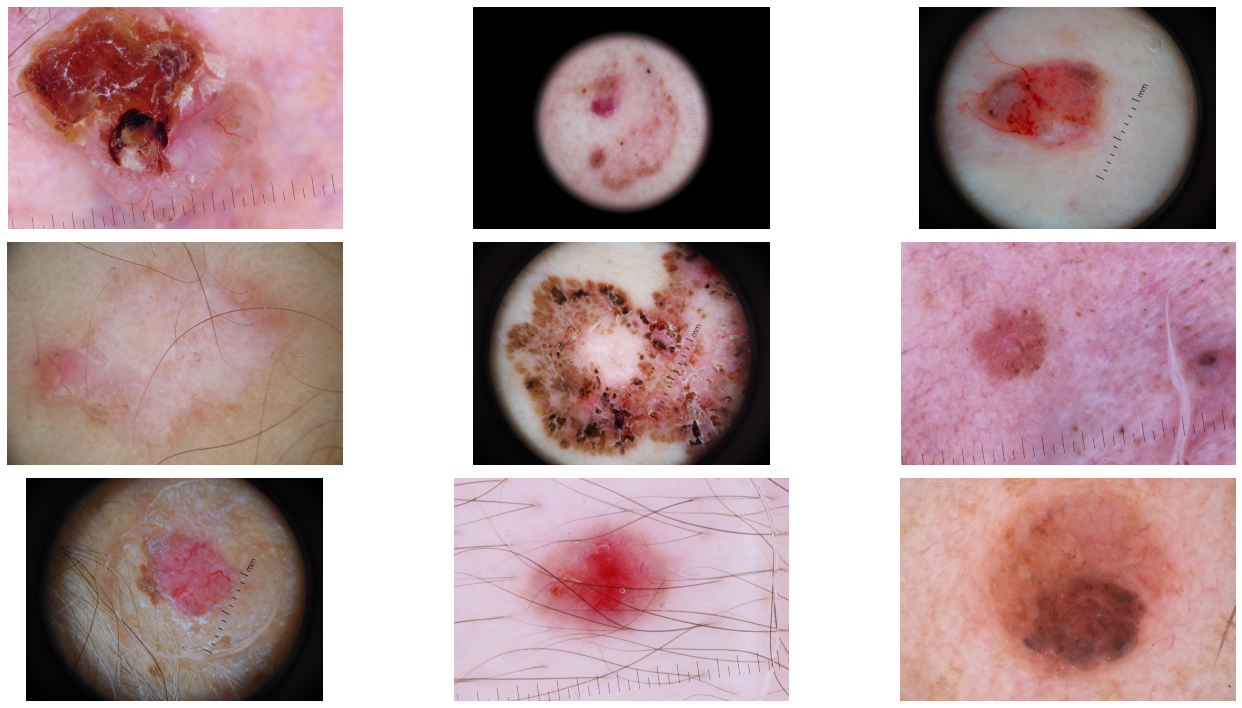

In [14]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(random_images[i])
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 3312 pixels width and 4416 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 139.1953 and the standard deviation is 31.1355


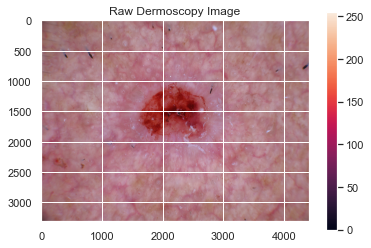

In [15]:
sample_img = df['Image Paths'][0]
raw_image = plt.imread(sample_img)
plt.imshow(raw_image)
plt.colorbar()
plt.title('Raw Dermoscopy Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

G:\My Drive\Libraries\Python\Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

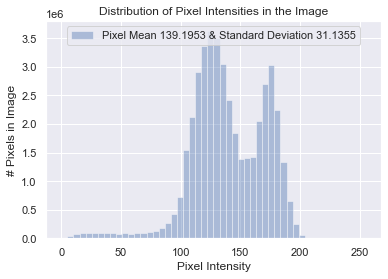

In [16]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(),
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [17]:

base_model = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=params['IMG_SHAPE'],
)
base_model.trainable = params['TRAINABLE']
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [20]:
if params['BATCH_NORM']:
    for layer in base_model.layers:
        if 'BatchNormalization' in layer.__class__.__name__:
            layer.trainable = True
            # print(layer.__class__.__name__)

In [21]:
if params['TRAINABLE'] and params['TUNE_LAYER'] is not None:
    #Fine-tune from this layer onwards
    fine_tune_at = 2 * len(base_model.layers) // 3

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

In [22]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Model Definition

In [23]:
def create_model(img_shape, class_num, lr=1e-5, metrics=None):

            preprocess_input = tf.keras.applications.resnet.preprocess_input
            inputs = tf.keras.Input(shape=img_shape)
            x = preprocess_input(inputs)
            x = data_augmentation(inputs)
            x = base_model(x, training=False)
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            x = tf.keras.layers.Dropout(0.2)(x)

            # x = tf.keras.layers.Dense(512, activation='relu')(x)
            # x = tf.keras.layers.Dropout(0.2)(x)
            outputs = tf.keras.layers.Dense(class_num, activation='softmax')(x)

            model = tf.keras.Model(inputs, outputs)

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=metrics)

            return model

def preprocess_dataset(imagepath, entries, labels, image_type='jpg', search_type='*', cache=True, batch_size=8, prefetch=True):

    dataset = ImageDataset(imagepath, entries=entries, labels=labels, image_type=image_type, search_type=search_type)
    dataset = dataset.create_image_dataset()
    dataset = ImageDataset.performance_config(dataset, cache=cache, batch_size=batch_size, prefetch=prefetch)

    return dataset

def evaluate_image(imagepath, target_size=None):

    img = tf.keras.utils.load_img(imagepath, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])

    return np.argmax(score), np.max(score)

### Model Training

In [24]:



callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              min_delta=1e-2,
                                              patience=5,
                                              verbose=1),
             tf.keras.callbacks.ModelCheckpoint(savepath,
                                      save_best_only=True,
                                      verbose=0,
                                      save_weights_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  factor=0.1,
                                                  patience=3,
                                                  min_delta=1e-2)
            ]



data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
                                         tf.keras.layers.RandomRotation(0.5),
                                         tf.keras.layers.RandomZoom(0.1),
                                         tf.keras.layers.RandomContrast(0.3),
                                         tf.keras.layers.RandomBrightness(0.2)])

### Train - Validation - Test Split

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

test_split = ShuffleSplit(n_splits=1, test_size=params['test_size'], random_state=params['SEED'])

dev_idx, test_idx = next(test_split.split(df, labels))

train_split = StratifiedShuffleSplit(n_splits=1, test_size=params['val_size'], random_state=params['SEED'])

train_idx, val_idx = next(train_split.split(df.loc[dev_idx, :], labels.loc[dev_idx, :]))

train = preprocess_dataset(imagepath, images[train_idx], oh_labels.loc[train_idx, :], batch_size=params['BATCH_SIZE'])
val = preprocess_dataset(imagepath, images[val_idx], oh_labels.loc[val_idx, :], batch_size=params['BATCH_SIZE'])

model = create_model(params['IMG_SHAPE'], params['CLASS_NUMBER'], params['LR'], metrics=params['metrics'])

# experiment, _ = read_metrics(savepath + 'results.xlsx')
#
# savepath = base_savepath + f"Experiment {experiment}/"

print(f"\nStarting Training")
print("===========================================")

hist = model.fit(train,
                      epochs=params['MAX_EPOCHS'],
                      validation_data=val,
                      callbacks=callbacks)

metrics = ["val_" + metric.lower() for metric in params['metrics']]

metric_values = [np.amax(hist.history[metric]) for metric in metrics]

train_metrics = {key:val for key, val in zip(metrics, metric_values ) }

log = Logger()
experiment = log.to_excel(params['base_savepath'] + 'results.xlsx', train_metrics)
log.to_json(params['base_savepath'] + f'Experiment_{experiment}_history.json', model.history.history)
log.to_json(params['base_savepath'] + f'Experiment_{experiment}_parameters.json', params)



Starting Training
Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 1.1604 - categorical_accuracy: 0.4234 - precision: 0.4660 - recall: 0.3109 - auc: 0.6145

NotFoundError: Failed to create a directory: /_temp; No such file or directory [Op:SaveV2]

### Test Performance

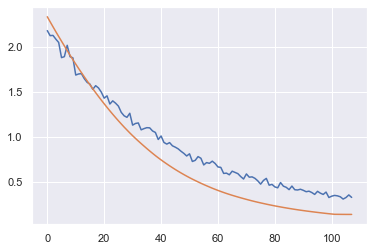

In [14]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [15]:
np.sum(oh_labels.loc[test_idx, :], axis=0)

High Risk      11
Superficial    15
Low Risk       16
dtype: int64

In [16]:

prediction_class = []
prediction_score = []
y_true = []

# ff = [1, 4, 59, 49, 90, 394, 210, 800, 700, 600, 500]

for image in test_idx:

    pred_class, pred_score = evaluate_image(df.loc[image, 'Image Paths'], target_size=params['IMG_SIZE'])

    prediction_score.append(pred_score)
    prediction_class.append(pred_class)

    if pred_class == np.argmax(oh_labels.loc[image, :]):
        y_true.append(1)
    else:
        y_true.append(0)

In [17]:
np.mean(y_true)

0.2619047619047619

In [21]:
precision, recall, f1, acc, bacc = get_metrics(one_hot_to_integers(oh_labels.loc[test_idx, :]), prediction_class, index=None, data=None, labels=None, classifier=None, verbose=True, filename=None)

Precision= 0.06859410430839002
Recall= 0.2619047619047619
F1 score= 0.10871518418688231
Balanced Accuracy 0.3333333333333333
Accuracy 0.2619047619047619


### Nested m*k Fold Stratified Cross Validation

In [15]:


outer_skf = split_data(df, labels, split_strategy='StratifiedKFold', n_splits=OUTER_SPLITS, shuffle=True, random_state=1369)

model_history = []

with tf.device("gpu:0"):

    for (dev_idx, test_idx), i in outer_skf:

        print(f"\nStarting Training on Outer Fold {i+1}/{OUTER_SPLITS}.")
        print("===========================================")

        inner_skf = split_data(df.loc[dev_idx, :], labels.loc[dev_idx, :], split_strategy='StratifiedKFold', n_splits=INNER_SPLITS, shuffle=True, random_state=1369)

        fold_history = []

        model_history[f"Fold_{i}_acc"] = []

        for (train_idx, val_idx), j in inner_skf:

            # train = ImageDataset(imagepath, entries=images[train_idx], labels=oh_labels.loc[train_idx, :], image_type='jpg', search_type='*')
            # val = ImageDataset(imagepath, entries=images[val_idx], labels=oh_labels.loc[val_idx, :], image_type='jpg', search_type='*')
            #
            # train = train.create_image_dataset()
            # val = val.create_image_dataset()
            #
            # train = ImageDataset.performance_config(train, cache=True, batch_size=BATCH_SIZE, prefetch=True)
            # val = ImageDataset.performance_config(val, cache=True, batch_size=BATCH_SIZE, prefetch=True)

            train = preprocess_dataset(imagepath, images[train_idx], oh_labels.loc[train_idx, :], batch_size=BATCH_SIZE)
            val = preprocess_dataset(imagepath, images[val_idx], oh_labels.loc[val_idx, :], batch_size=BATCH_SIZE)

            # image_batch, label_batch = next(iter(train))
            # feature_batch = base_model(image_batch)
            # # print(feature_batch.shape)
            # global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
            # feature_batch_average = global_average_layer(feature_batch)

            model = create_model(IMG_SHAPE, CLASS_NUMBER, LR, metrics=metrics)

            experiment, _ = read_metrics(base_savepath + 'results.xlsx')

            savepath = base_savepath + f"Experiment {experiment}/"

            print(f"\nStarting Training on Inner Fold {j+1}/{INNER_SPLITS}.")
            print("===========================================")

            fold_hist = model.fit(train,
                                  epochs=MAX_EPOCHS,
                                  validation_data=val,
                                  callbacks=callbacks)

            fold_metrics = [np.amax(fold_hist.history["val_" + metric.lower()]) for metric in metrics]

            save_metrics(base_savepath + 'results.xlsx', metrics=fold_metrics, labels=metrics)

            # fold_history.append(fold_hist)

            # record the inner folds history
            model_history[f"Fold_{i}.{j}_hist"] = fold_hist.history

            model_history[f"Fold_{i}.{j}_preds"] = []
            model_history[f"Fold_{i}.{j}_scores"] = []
            model_history[f"Fold_{i}.{j}_acc"] = []
            model_history[f"Fold_{i}.{j}_true"] = []

            for image in test_idx:

                        pred_class, pred_score = evaluate_image(df.loc[image, 'Image Paths'], target_size=IMG_SIZE)

                        model_history[f"Fold_{i}.{j}_scores"].append(pred_score)
                        model_history[f"Fold_{i}.{j}_preds"].append(pred_class)

                        if pred_class == np.argmax(oh_labels.loc[image, :]):
                            model_history[f"Fold_{i}.{j}_true"].append(1)
                        else:
                            model_history[f"Fold_{i}.{j}_true"].append(0)

            print(f"          Fold {i}.{j} Results")
            print("**|" + "-"* 30 + "|**")
            # m = tf.keras.metrics.Accuracy()
            # m.update_state(model_history[f"Fold_{i}.{j}_preds"], labels.loc[test_idx, :])
            accuracy = np.mean(model_history[f"Fold_{i}.{j}_true"])
            model_history[f"Fold_{i}.{j}_acc"].append(accuracy)
            print(f"  |       Accuracy = {accuracy:.3f}       |")


        acc_avg = np.mean(model_history[f"Fold_{i}.{j}_acc"])
        acc_std = np.std(model_history[f"Fold_{i}.{j}_acc"])

        model_history[f"Fold_{i}_acc"] = acc_avg
        model_history[f"Fold_{i}_std"] = model_history[f"Fold_{i}.{j}_acc"]

        print(f"\n            Fold {i} Averaged Results")
        print("**|" + "-"* 40 + "|**")
        print(f"  |          Mean Accuracy = {acc_avg:.3f}         |")
        print(f"  |      Mean Standard Deviation = {acc_std:.3f}   |")

json.dump(model_history, open(base_savepath + f"history.json", 'w'))


Starting Training on Outer Fold 1/16.

Starting Training on Inner Fold 1/5.
Epoch 1/100
10/10 [==============================] - 15s 702ms/step - loss: 2.2101 - categorical_accuracy: 0.1442 - precision: 0.1086 - recall: 0.0840 - auc: 0.2426 - val_loss: 1.9415 - val_categorical_accuracy: 0.1962 - val_precision: 0.1071 - val_recall: 0.0759 - val_auc: 0.2704 - lr: 1.0000e-05
Epoch 2/100
10/10 [==============================] - 3s 326ms/step - loss: 2.1143 - categorical_accuracy: 0.1521 - precision: 0.1364 - recall: 0.1046 - auc: 0.2650 - val_loss: 1.7957 - val_categorical_accuracy: 0.2215 - val_precision: 0.1964 - val_recall: 0.1392 - val_auc: 0.3207 - lr: 1.0000e-05
Epoch 3/100
10/10 [==============================] - 3s 328ms/step - loss: 1.9598 - categorical_accuracy: 0.2044 - precision: 0.1830 - recall: 0.1363 - auc: 0.3251 - val_loss: 1.6565 - val_categorical_accuracy: 0.2532 - val_precision: 0.2411 - val_recall: 0.1709 - val_auc: 0.3774 - lr: 1.0000e-05
Epoch 4/100
10/10 [=========

TypeError: Object of type History is not JSON serializable

In [54]:
def fold_plots(hist, outer_splits, inner_splits, figsize=(20, 20)):

    fig, axs = plt.subplots(ncols=inner_splits, nrows=outer_splits, figsize=figsize, #(20*outer_splits//6, inner_splits*4),
                            constrained_layout=False)

    for outer_fold in range(outer_splits):
        for inner_fold in range(inner_splits):

            w = np.max(hist[f"Fold_{outer_fold}.{inner_fold}_hist"][inner_fold].epoch)
            max_loss = np.max(hist[f"Fold_{outer_fold}.{inner_fold}_hist"][inner_fold].history['loss'])
            max_val_loss = np.max(hist[f"Fold_{outer_fold}.{inner_fold}_hist"][inner_fold].history['val_loss'])
            h = np.max([max_loss, max_val_loss])

            loss, = axs[outer_fold, inner_fold].plot(hist[f"Fold_{outer_fold}.{0}_hist"][inner_fold].history['loss'])
            val_loss, = axs[outer_fold, inner_fold].plot(hist[f"Fold_{outer_fold}.{0}_hist"][inner_fold].history['val_loss'])
            axs[outer_fold, inner_fold].set_title(f'Loss curves on Fold {outer_fold+1}.{inner_fold+1}')
            axs[outer_fold, inner_fold].set_xlabel('Epoch')
            axs[outer_fold, inner_fold].legend([loss, val_loss], ['train loss', 'val loss'] )
            axs[outer_fold, inner_fold].annotate(f"Fold {outer_fold}.{inner_fold} Accuracy= {hist[f'Fold_{outer_fold}.{inner_fold}_acc'][0]:.2f}", (w//2+w//10, h/2),
                                                 transform=axs[outer_fold, inner_fold].transAxes,
                                                 ha='center', va='center', fontsize=12, color='darkgrey')
            axs[outer_fold, inner_fold].annotate(f"Fold {outer_fold} Accuracy= {hist[f'Fold_{outer_fold}_acc']:.2f}", (w//2+w//10, 2*h/3),
                                                 transform=axs[outer_fold, inner_fold].transAxes,
                                                 ha='center', va='center', fontsize=12, color='darkgrey')


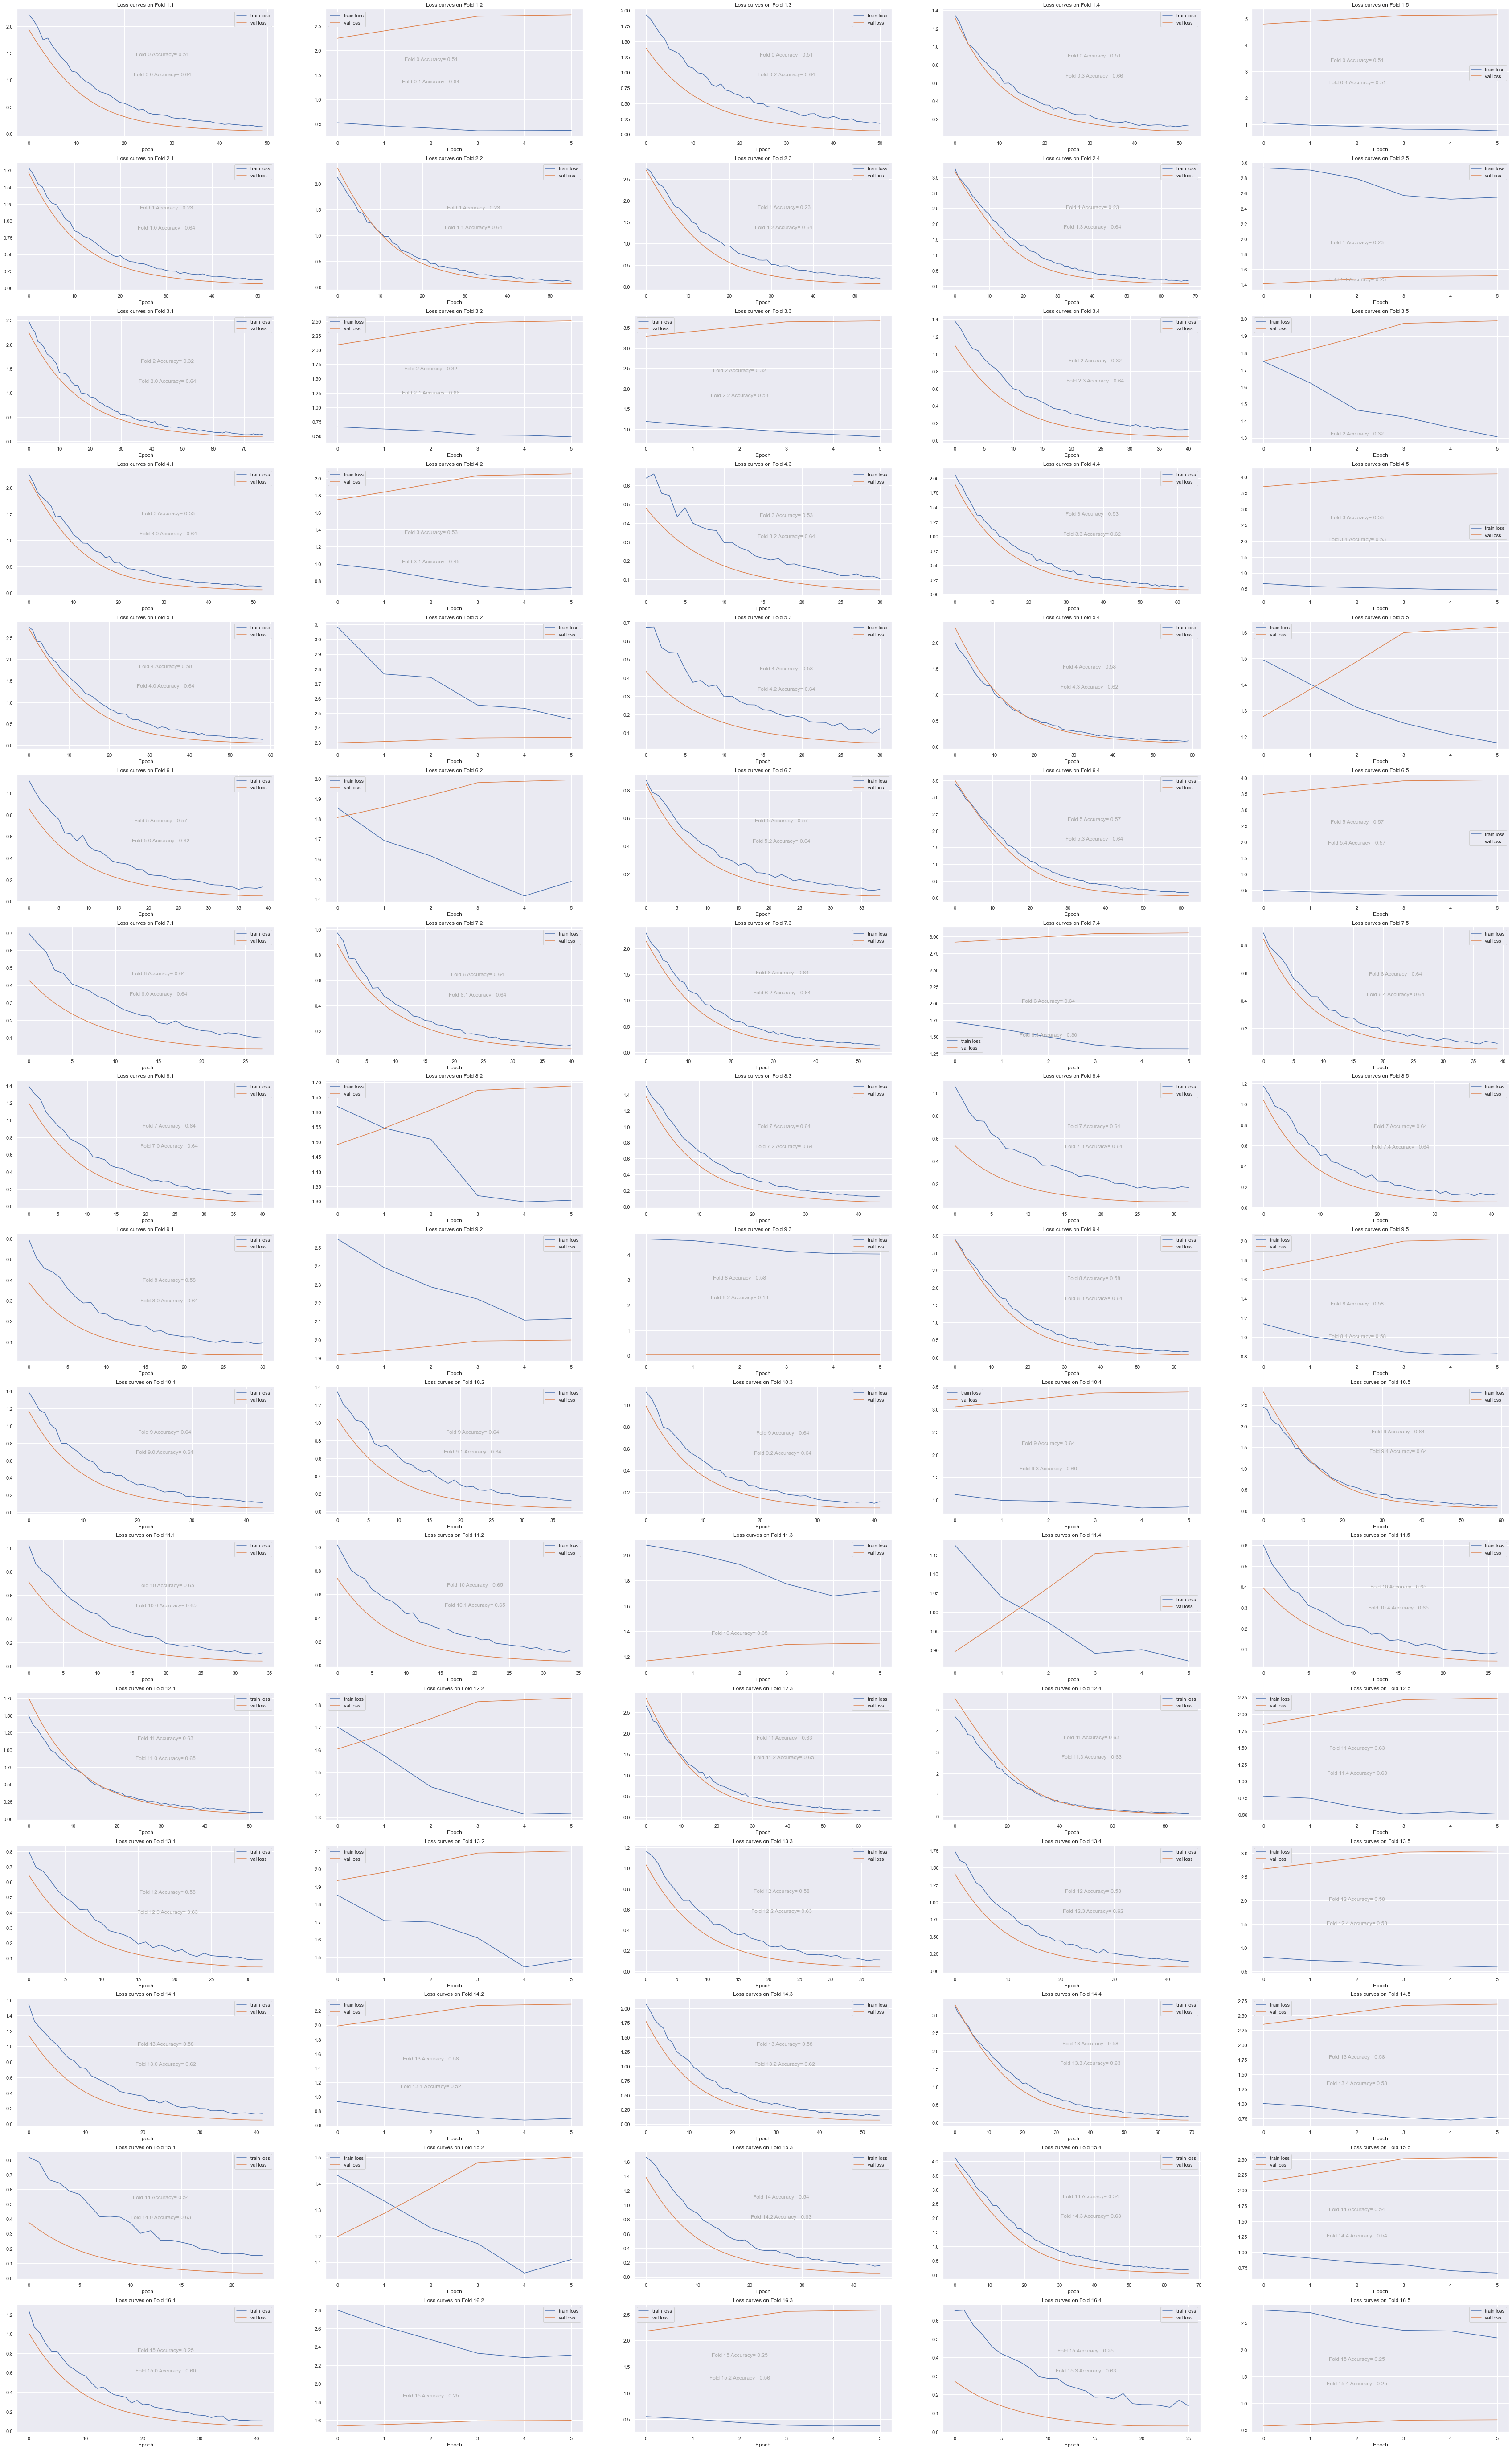

In [55]:
fold_plots(model_history, OUTER_SPLITS, INNER_SPLITS, figsize=(60, 100))

In [60]:
# create json object from dictionary
json = json.dumps(model_history)

# open file for writing, "w"
f = open(base_savepath + f"history.json", "w")

# write json object to file
f.write(json)

# close file
f.close()

TypeError: Object of type History is not JSON serializable

In [63]:
import csv
w = csv.writer(open(base_savepath + f"history.csv", "w"))
for key, val in model_history.items():
    w.writerow([key, val])

In [15]:

for fold in range(NUM_SPLITS):
    json.dump(history[fold].history, open(base_savepath + f"Fold_{fold}.json", 'w'))

TypeError: Object of type float32 is not JSON serializable

In [44]:
def unpack_metrics(filepath, number_of_splits):

    loss = []
    val_loss = []
    acc = []
    val_acc = []
    val_auc = []
    val_recall = []
    val_precision = []
    val_f1 = []


    for fold in range(number_of_splits):

        with open(filepath + f"Fold_{fold}.json") as f:

            history = json.load(f)

            loss.append(history['loss'])
            val_loss.append(history['val_loss'])
            acc.append(history['categorical_accuracy'])
            val_acc.append(history['val_categorical_accuracy'])
            val_auc.append(history['val_auc'])
            val_recall.append(history['val_recall'])
            val_precision.append(history['val_precision'])
            val_f1.append(2 * np.array(val_precision[fold]) * np.array(val_recall[fold]) / np.array((val_precision[fold]) + np.array(val_recall[fold])))

    return {'loss':loss, 'val_loss':val_loss, 'acc':acc, 'val_acc':val_acc, 'val_auc':val_auc, 'val_recall':val_recall, 'val_precision':val_precision, 'val_f1':val_f1}


In [52]:
def plots(hist):
    fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(20, 20),
                            constrained_layout=True)

    for fold in range(NUM_SPLITS):
        loss, = axs[0,fold].plot(hist['loss'][fold])
        val_loss, = axs[0,fold].plot(hist['val_loss'][fold])
        axs[0,fold].set_title(f'Loss curves on Fold {fold+1}')
        axs[0,fold].set_xlabel('Epoch')
        axs[0,fold].legend([loss, val_loss], ['train loss', 'val loss'] )

        acc, = axs[1,fold].plot(hist['acc'][fold])
        val_acc, = axs[1,fold].plot(hist['val_acc'][fold])
        axs[1,fold].set_title(f'Accuracy on Fold {fold+1}')
        axs[1,fold].set_xlabel('Epoch')
        axs[1,fold].legend([acc, val_acc], ['train accuracy', 'val accuracy'])

        auc, = axs[2,fold].plot(hist['val_auc'][fold])
        axs[2,fold].set_title(f'AUC on Fold {fold+1}')
        axs[2,fold].set_xlabel('Epoch')

        precision, = axs[3,fold].plot(hist['val_precision'][fold])
        axs[3,fold].set_title(f'Precision on Fold {fold+1}')
        axs[3,fold].set_xlabel('Epoch')

        recall, = axs[4,fold].plot(hist['val_recall'][fold])
        axs[4,fold].set_title(f'Recall on Fold {fold+1}')
        axs[4,fold].set_xlabel('Epoch')

        f1, = axs[5,fold].plot(hist['val_f1'][fold])
        axs[5,fold].set_title(f'F1 score on Fold {fold+1}')
        axs[5,fold].set_xlabel('Epoch')